In [1]:
using PyCall
using Statistics
using PyPlot
np = pyimport("numpy")

PyObject <module 'numpy' from '/Users/honghaoyu/.julia/conda/3/aarch64/lib/python3.12/site-packages/numpy/__init__.py'>

In [2]:
mutable struct Particle
    Ptype::Int64
    life_time::Int64
    num_reprod::Int64
    num_kill::Int64
    migration_dist::Int64
end

In [3]:
function initialization(Ly, Lx, rho_total)
    config_obj = Matrix{Particle}(undef, Ly, Lx)
    
    Acount = 0
    Bcount = 0
    Ccount = 0
    Tcount = 0
    iterator = 0
    numOfOneType = convert(Int64, floor(Lx*Ly*rho_total/3))
    for i in axes(config_obj, 1), j in axes(config_obj, 2)
        temp_Part = Particle(0, 0, 0, 0, 0)
        config_obj[i, j] = temp_Part
    end
    while (Acount < numOfOneType) || (Bcount < numOfOneType) || (Ccount < numOfOneType)
        i = rand(1:Ly)
        j = rand(1:Lx)
        if (config_obj[i, j].Ptype == 0) && (iterator%3 == 0) && (Acount<numOfOneType)
            Acount += 1
            Tcount += 1
            config_obj[i, j].Ptype = 1
        end
        if (config_obj[i, j].Ptype == 0) && (iterator%3 == 1) && (Bcount<numOfOneType)
            Bcount += 1
            Tcount += 1
            config_obj[i, j].Ptype = 2
        end
        if (config_obj[i, j].Ptype == 0) && (iterator%3 == 2) && (Ccount<numOfOneType)
            Ccount += 1
            Tcount += 1
            config_obj[i, j].Ptype = 3
            #config_obj[i, j].y_coord = i
            #config_obj[i, j].x_coord = j
        end
        iterator += 1
    end
    #println("total number of sites: ", Ly*Lx)
    #println("number of A: ", Acount)
    #println("number of B: ", Bcount)
    #println("number of C: ", Ccount)
    #println("number of particles: ", Tcount)
    return config_obj
end

initialization (generic function with 1 method)

In [4]:
function calcRate(selection_rate, death_rate, reproduction_rate, walk_rate)
    RN = rand()
    total_rate = selection_rate + death_rate + reproduction_rate + walk_rate
    if RN < (selection_rate/total_rate)
        return("Selection")
    elseif RN < ((selection_rate+death_rate)/total_rate)
        return("Death")
    elseif RN < ((selection_rate+death_rate+reproduction_rate)/total_rate)
        return("Reproduction")
    else
        return("Walk")
    end
end

calcRate (generic function with 1 method)

In [5]:
function calcDir()
    RN = rand(1: 4)
    if RN == 1
        return("Right")
    end
    if RN == 2
        return("Above")
    end
    if RN == 3
        return("Left")
    end
    if RN == 4
        return("Below")
    end
end

calcDir (generic function with 1 method)

In [6]:
#Here we denote A=1, B=2, C=3, and emtpy sites=0
#We also pass the action rates for use in the decision process
function moveCheck(config_obj, selection_rate, death_rate, reproduction_rate, move_rate)
    for i = 1:size(config_obj)[1]*size(config_obj)[2]
        a = rand(1: size(config_obj)[1])
        b = rand(1: size(config_obj)[2])
        if config_obj[a, b].Ptype != 0
            
            if config_obj[a, b].Ptype == 1
                dirc = calcDir()
                action = calcRate(selection_rate, death_rate, reproduction_rate, move_rate)
                updateConfig(config_obj, a, b, dirc, action)
            elseif config_obj[a, b].Ptype == 2
                dirc = calcDir()
                action = calcRate(selection_rate, death_rate, reproduction_rate, move_rate)
                updateConfig(config_obj, a, b, dirc, action)
            elseif config_obj[a, b].Ptype == 3
                dirc = calcDir()
                action = calcRate(selection_rate, death_rate, reproduction_rate, move_rate)
                updateConfig(config_obj, a, b, dirc, action)
            end
            
        end
    end
    return config_obj
end

moveCheck (generic function with 1 method)

In [7]:
function updateConfig(config_obj, a, b, dirc, action)
    neigh_i = 0
    neigh_j = 0
    if dirc == "Right"
        neigh_i = a
        neigh_j = 1+mod(b,size(config_obj)[2])
    end
    if dirc == "Above"
        neigh_i = 1+mod(a,size(config_obj)[1])
        neigh_j = b
    end
    if dirc == "Left"
        neigh_i = a
        neigh_j = 1+mod(b-2,size(config_obj)[2])
    end
    if dirc == "Below"
        neigh_i = 1+mod(a-2,size(config_obj)[1])
        neigh_j = b
    end
    if action == "Walk"
        if config_obj[neigh_i, neigh_j].Ptype != config_obj[a, b].Ptype
            config_obj[a, b], config_obj[neigh_i, neigh_j] = config_obj[neigh_i, neigh_j], config_obj[a, b]
            updateWalk(config_obj, a, b, neigh_i, neigh_j)
        end
    end
    if action == "Death"
        config_obj[a, b].Ptype = 0
        updateDeath(config_obj, a, b)
    end
    if action == "Selection"
        if config_obj[neigh_i, neigh_j].Ptype == 1+mod(config_obj[a, b].Ptype,3)
            config_obj[neigh_i, neigh_j].Ptype = 0
            updateSelection(config_obj, a, b, neigh_i, neigh_j)
        end
    end
    if action == "Reproduction"
        if config_obj[neigh_i, neigh_j].Ptype == 0
            config_obj[neigh_i, neigh_j].Ptype = config_obj[a, b].Ptype
            updateReproduction(config_obj, a, b, neigh_i, neigh_j)
        end
    end
    return config_obj
end

updateConfig (generic function with 1 method)

In [15]:
function updateWalk(config_obj, a, b, neigh_i, neigh_j)
    config_obj[a, b].migration_dist += 1
    config_obj[neigh_i, neigh_j].migration_dist += 1
    return config_obj
end

updateWalk (generic function with 1 method)

In [16]:
function updateDeath(config_obj, a, b)
    config_obj[a, b].life_time = -1
    config_obj[a, b].num_kill = 0
    config_obj[a, b].num_reprod = 0
    config_obj[a, b].migration_dist = 0
    return config_obj
end

updateDeath (generic function with 1 method)

In [19]:
function updateSelection(config_obj, a, b, neigh_i, neigh_j)
    config_obj[neigh_i, neigh_j].life_time = -1
    config_obj[neigh_i, neigh_j].num_kill = 0
    config_obj[neigh_i, neigh_j].num_reprod = 0
    config_obj[neigh_i, neigh_j].migration_dist = 0
            
    config_obj[a, b].num_kill += 1
    return config_obj
end

updateSelection (generic function with 1 method)

In [21]:
function updateReproduction(config_obj, a, b, neigh_i, neigh_j)
    config_obj[neigh_i, neigh_j].life_time = -1
    config_obj[neigh_i, neigh_j].num_kill = 0
    config_obj[neigh_i, neigh_j].num_reprod = 0
    config_obj[neigh_i, neigh_j].migration_dist = 0
            
    config_obj[a, b].num_reprod += 1
    return config_obj
end

updateReproduction (generic function with 1 method)

In [23]:
function trackNum(config_obj, norm)
    Acount = 0
    Bcount = 0
    Ccount = 0
    Tcount = 0
    for i in axes(config_obj,1), j in axes(config_obj,2)
        if config_obj[i, j].Ptype == 1
            Acount += 1
        end
        if config_obj[i, j].Ptype == 2
            Bcount += 1
        end
        if config_obj[i, j].Ptype == 3
            Ccount += 1
        end
        Tcount += 1
    end
    #println("The number of A particles is ", Acount)
    #println("The number of B particles is ", Bcount)
    #println("The number of C particles is ", Ccount)
    if norm == 1
        return (Acount/Tcount), (Bcount/Tcount), (Ccount/Tcount)
    else
        return Acount, Bcount, Ccount
    end
end

trackNum (generic function with 1 method)

In [25]:
function convertToPlot(config_obj)
    config = zeros(size(config_obj)[1], size(config_obj)[2])
    for i in axes(config_obj,1), j in axes(config_obj,2)
        config[i, j] = config_obj[i, j].Ptype
    end
    return config
end

convertToPlot (generic function with 1 method)

In [27]:
function configPlot(f, config, n_, i)
    #empty=0, red=1, blue=2, yellow=3
    colors=["black", "red", "blue", "yellow"]
    cmap = matplotlib.colors.ListedColormap(colors)
    
    sp =  f.add_subplot(2, 4, n_)    
    plt.pcolor(config, cmap=cmap, vmin = 0, vmax = 3) 
    StepString = string("t = ", i)
    plt.title(StepString, fontsize=50)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
end

configPlot (generic function with 1 method)

In [29]:
function output_life_time(config_obj)
    life_time_dist = []
    for i in axes(config_obj,1), j in axes(config_obj,2)
        if config_obj[i, j].Ptype!= 0
            append!(life_time_dist, config_obj[i, j].life_time)
        end
    end
    return life_time_dist
end

output_life_time (generic function with 1 method)

In [31]:
function output_num_kill(config_obj)
    num_kill_dist = []
    for i in axes(config_obj,1), j in axes(config_obj,2)
        if config_obj[i, j].Ptype!= 0
            append!(num_kill_dist, config_obj[i, j].num_kill)
        end
    end
    return num_kill_dist
end

output_num_kill (generic function with 1 method)

In [33]:
function output_num_reprod(config_obj)
    num_reprod_dist = []
    for i in axes(config_obj,1), j in axes(config_obj,2)
        if config_obj[i, j].Ptype!= 0
            append!(num_reprod_dist, config_obj[i, j].num_reprod)
        end
    end
    return num_reprod_dist
end

output_num_reprod (generic function with 1 method)

In [35]:
function output_migration_dist(config_obj)
    migration_dist_dist = []
    for i in axes(config_obj,1), j in axes(config_obj,2)
        if config_obj[i, j].Ptype!= 0
            append!(migration_dist_dist, config_obj[i, j].migration_dist)
        end
    end
    return migration_dist_dist
end

output_migration_dist (generic function with 1 method)

In [37]:
function simulate(Ly, Lx, rho, selection_rate, death_rate, reproduction_rate, move_rate, steps)
    config_obj = initialization(Ly, Lx, rho)
    config = zeros(Ly, Lx)
    f = figure(figsize=(16, 10), dpi=80)
    config = convertToPlot(config_obj)
    configPlot(f, config, 1, 0)
    
    A_traj, B_traj, C_traj = [], [], []
    #life_time_dist, num_kill_dist, num_reprod_dist, migration_dist_dist = [], [], [], []
    
    MCTimeStep = steps
    for i = 1:MCTimeStep
        config_obj = moveCheck(config_obj, selection_rate, death_rate, reproduction_rate, move_rate) 
        for i in axes(config_obj,1), j in axes(config_obj,2)
            config_obj[i, j].life_time += 1
        end
        
        append!(A_traj, trackNum(config_obj, 1)[1])
        append!(B_traj, trackNum(config_obj, 1)[2])
        append!(C_traj, trackNum(config_obj, 1)[3])
        
        if i == Int(steps*0.001)
            config = convertToPlot(config_obj)
            configPlot(f, config, 2, i)
        end        
        if i == Int(steps*0.01)
            config = convertToPlot(config_obj)
            configPlot(f, config, 3, i)
        end      
        if i == Int(steps*0.1)
            config = convertToPlot(config_obj)
            configPlot(f, config, 4, i)
        end
        if i == Int(steps*0.3)
            config = convertToPlot(config_obj)
            configPlot(f, config, 5, i)
        end        
        if i == Int(steps*0.5)
            config = convertToPlot(config_obj)
            configPlot(f, config, 6, i)
        end      
        if i == Int(steps*0.7)
            config = convertToPlot(config_obj)
            configPlot(f, config, 7, i)
        end
        if i == Int(steps)
            config = convertToPlot(config_obj)
            configPlot(f, config, 8, i)
        end
        
    end
    
    #now extract life_time, num_kill, num_reprod, migration_dist
    #life_time_dist = output_life_time(config_obj)
    #num_kill_dist = output_num_kill(config_obj)
    #num_reprod_dist = output_num_reprod(config_obj)
    #migration_dist_dist = output_migration_dist(config_obj)
    
    #return A_traj, B_traj, C_traj
    #return life_time_dist, num_kill_dist, num_reprod_dist, migration_dist_dist
    return config, A_traj, B_traj, C_traj
end

simulate (generic function with 1 method)

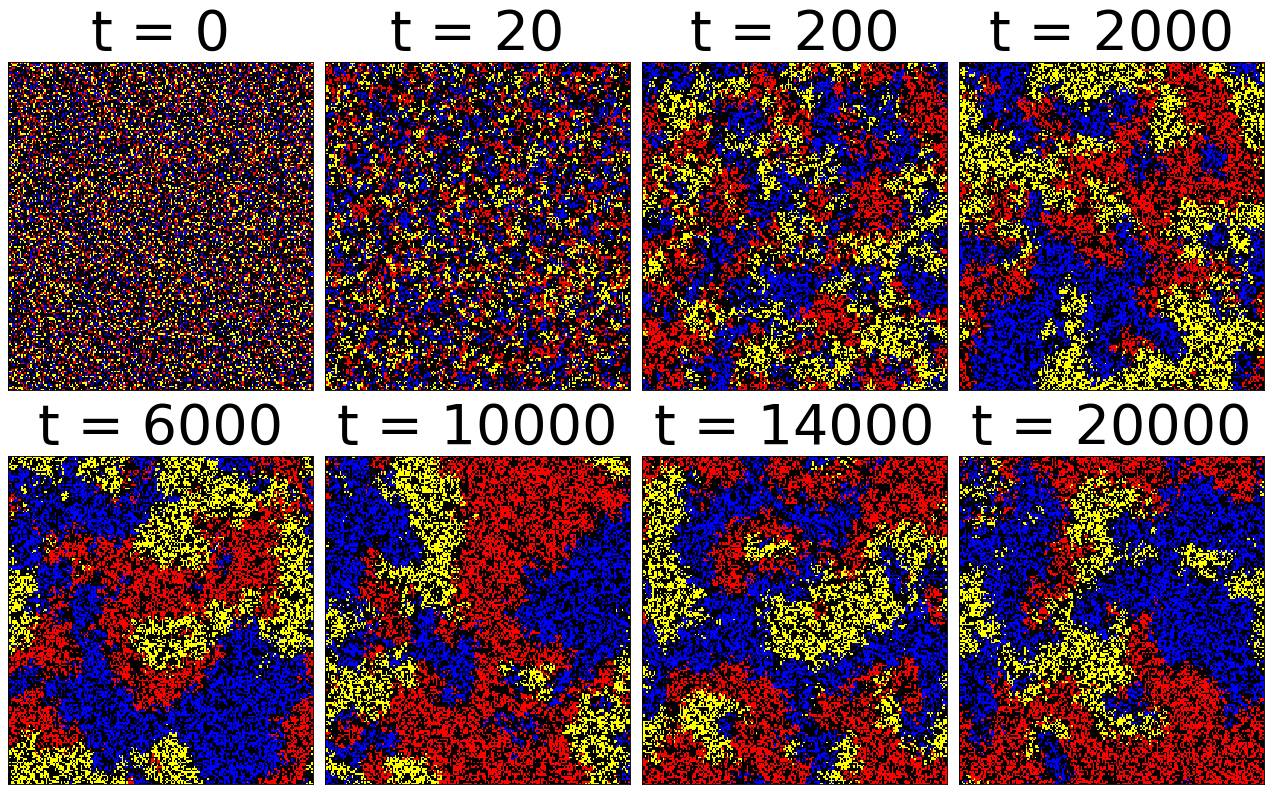

([1.0 0.0 … 1.0 1.0; 0.0 0.0 … 0.0 1.0; … ; 0.0 2.0 … 1.0 2.0; 1.0 0.0 … 1.0 0.0], Any[0.13375, 0.1344, 0.135375, 0.1358, 0.135075, 0.1355, 0.135275, 0.13445, 0.1337, 0.13475  …  0.1721, 0.17265, 0.1721, 0.173675, 0.173525, 0.1721, 0.1737, 0.1741, 0.1722, 0.1705], Any[0.1357, 0.1347, 0.13695, 0.137375, 0.138575, 0.137925, 0.137025, 0.138475, 0.138, 0.1372  …  0.196725, 0.19685, 0.197425, 0.19955, 0.197975, 0.197325, 0.1979, 0.197325, 0.195725, 0.194675], Any[0.132875, 0.13145, 0.130025, 0.130675, 0.130325, 0.130175, 0.130025, 0.129425, 0.13065, 0.128875  …  0.1024, 0.102075, 0.1017, 0.1008, 0.1002, 0.100275, 0.099475, 0.099575, 0.099375, 0.0997])

In [43]:
config, a, b, c = simulate(200, 200, 0.4, 1, 0.45, 1, 1, 20000)


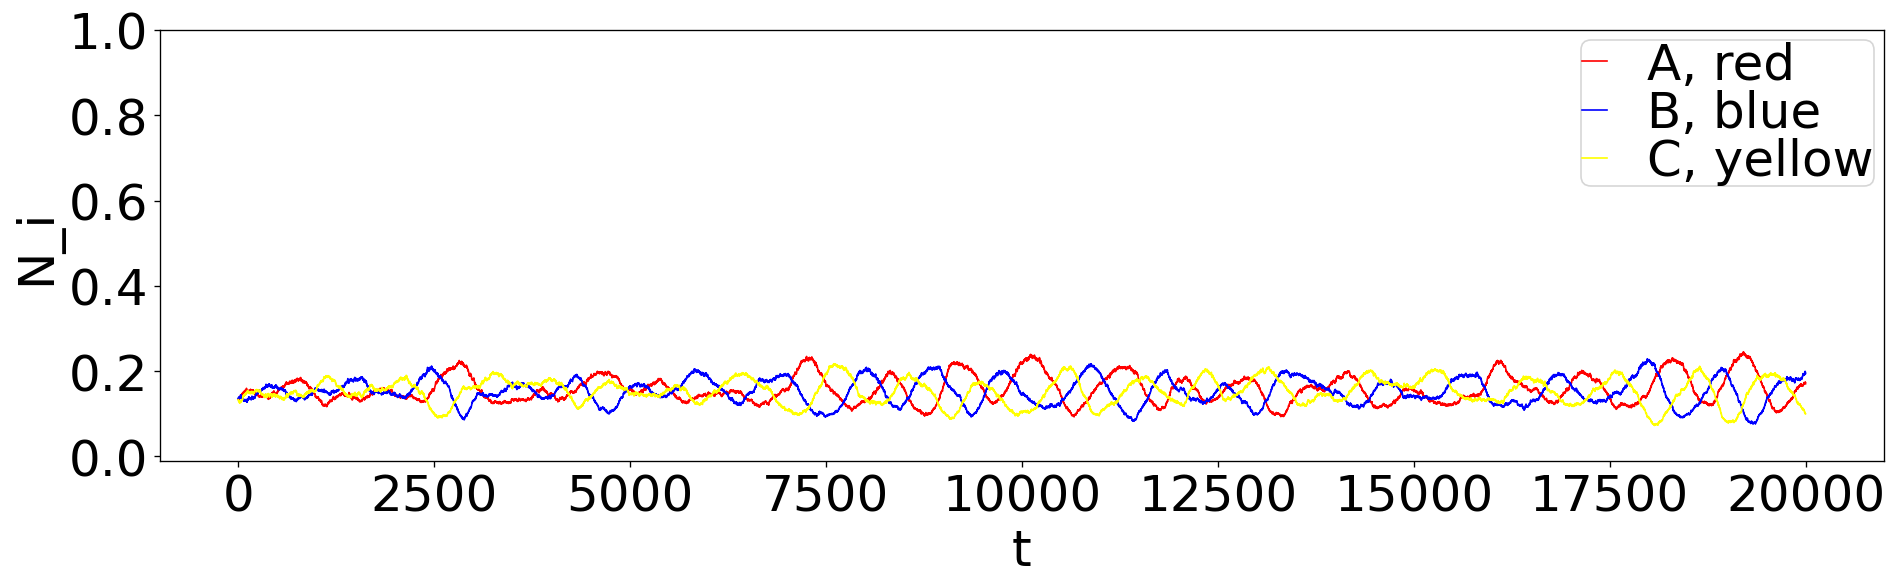

In [44]:
t = np.linspace(1, 20000, 20000)
f = figure(figsize=(16, 5), dpi=120)
plt.plot(t, a, color = "red", label = "A, red", linewidth=1)
plt.plot(t, b, color = "blue", label = "B, blue", linewidth=1)
plt.plot(t, c, color = "yellow", label = "C, yellow", linewidth=1)
plt.xlabel("t", fontsize=30)
plt.ylabel("N_i", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(-0.01, 1)
plt.legend(fontsize=30, borderpad=0.01, labelspacing=0.01, handlelength=0.5, borderaxespad=0.2)
plt.tight_layout()

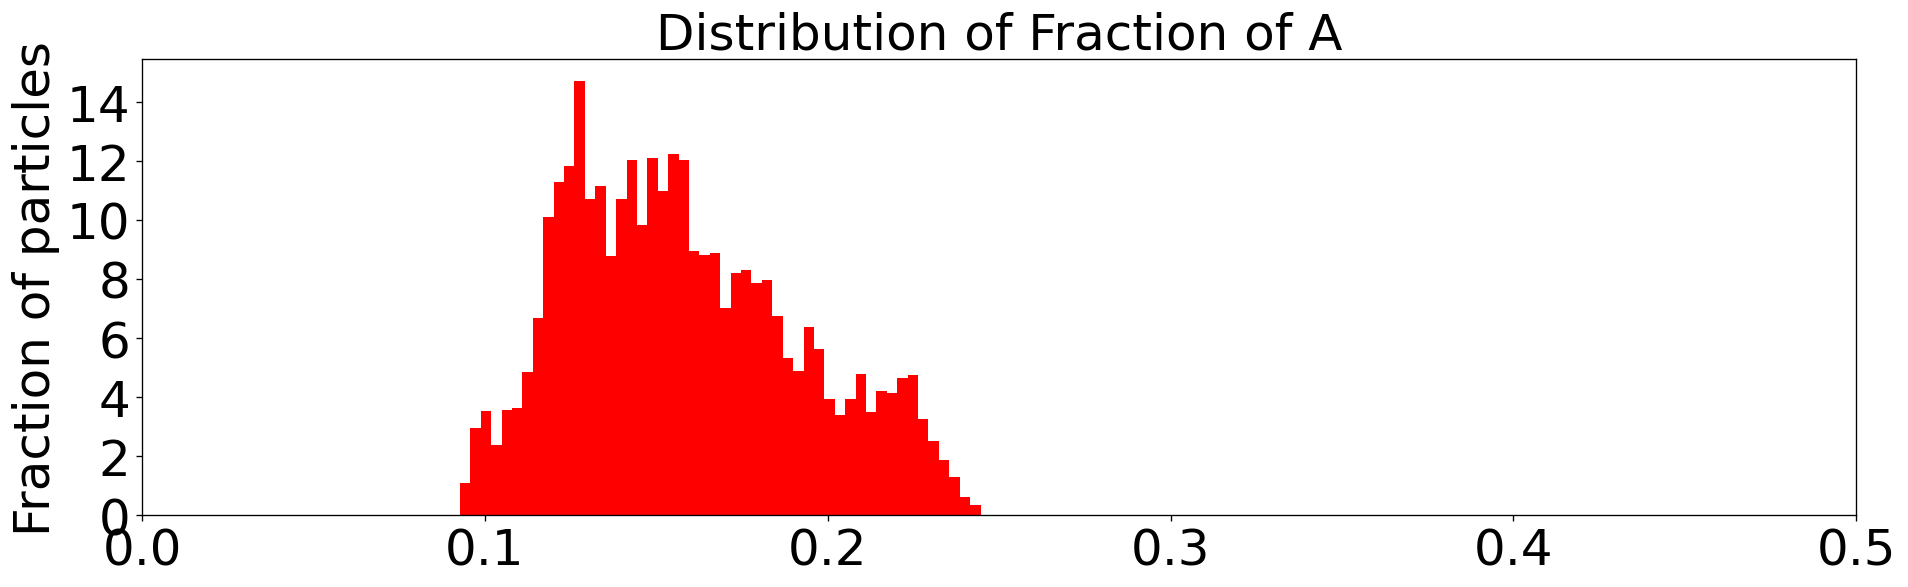

In [45]:
f = figure(figsize=(16, 5), dpi=120)
plt.hist(a[5000:20000], color = "red", label = "Red Particles", linewidth=3, density = 1, bins = 50)
plt.title("Distribution of Fraction of A", fontsize=30)
plt.ylabel("Fraction of particles", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlim(0, 0.5)
plt.tight_layout()

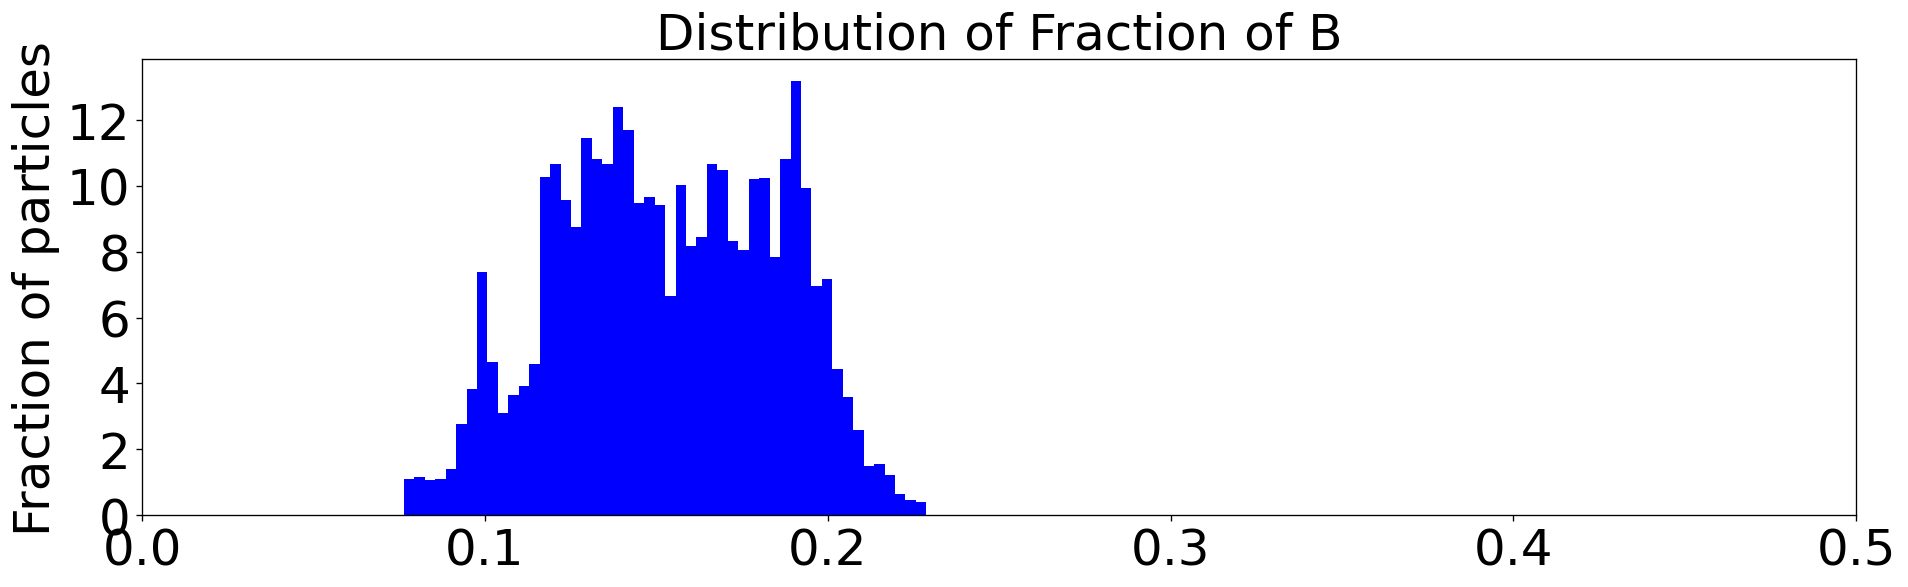

In [46]:
f = figure(figsize=(16, 5), dpi=120)
plt.hist(b[5000:20000], color = "blue", label = "Blue Particles", linewidth=3, density = 1, bins = 50)
plt.title("Distribution of Fraction of B", fontsize=30)
plt.ylabel("Fraction of particles", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlim(0, 0.5)
plt.tight_layout()

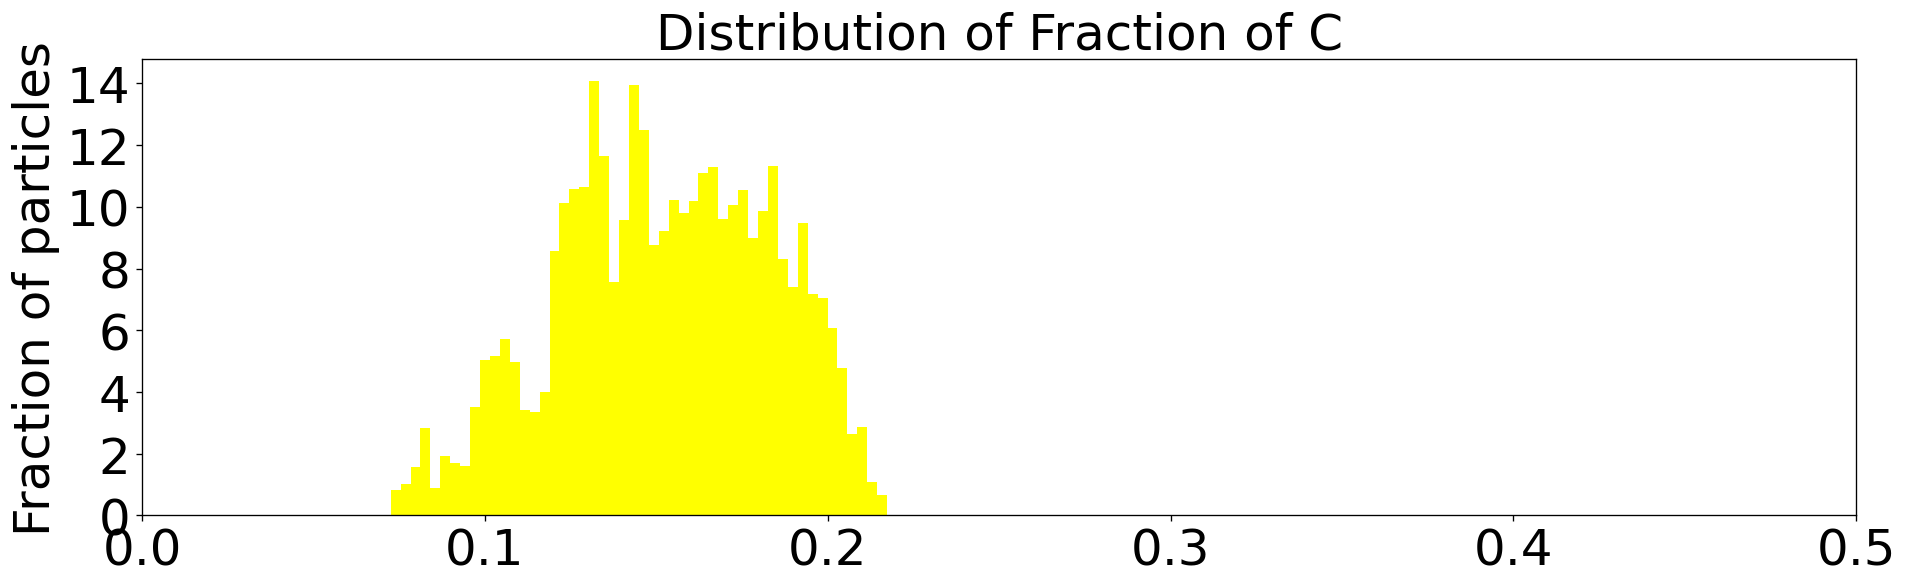

In [47]:
f = figure(figsize=(16, 5), dpi=120)
plt.hist(c[5000:20000], color = "yellow", label = "Yellow Particles", linewidth=3, density = 1, bins = 50)
plt.title("Distribution of Fraction of C", fontsize=30)
plt.ylabel("Fraction of particles", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlim(0, 0.5)
plt.tight_layout()